<a href="https://colab.research.google.com/github/Reemaalt/Detection-of-Hallucination-in-Arabic/blob/main/SE_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding SE values to the human labels file

**run once**

In [ ]:
import json

def update_with_semantic_entropy():
    with open('human_sample_xor_tydiqa.json', 'r', encoding='utf-8') as f:
        human_sample = json.load(f)
    with open('semantic_entropy_Llama3.1-8b_xor_tydiqa_results.json', 'r', encoding='utf-8') as f:
        semantic_entropy_data = json.load(f)

    # Create a mapping of questions to their semantic entropy data
    question_to_entropy = {}
    for key, data in semantic_entropy_data.items():
        question = data.get('question')
        if question:
            question_to_entropy[question] = {
                'semantic_entropy': data.get('semantic_entropy'),
                'num_clusters': data.get('num_clusters'),
                'cluster_probabilities': data.get('cluster_probabilities')
            }

    # Update
    updated_count = 0
    for key, data in human_sample.items():
        question = data.get('question')
        if question and question in question_to_entropy:
            # Add semantic entropy data to the human sample
            entropy_data = question_to_entropy[question]
            data['semantic_entropy'] = entropy_data['semantic_entropy']
            updated_count += 1

    # Save the updated human sample
    with open('human_sample_xor_tydiqa_updated.json', 'w', encoding='utf-8') as f:
        json.dump(human_sample, f, ensure_ascii=False, indent=2)

    print(f"Updated {updated_count} questions with semantic entropy data")
    print(f"Saved to human_sample_xor_tydiqa_updated.json")

update_with_semantic_entropy()

Updated 100 questions with semantic entropy data
Saved to human_sample_xor_tydiqa_updated.json


# AUROC
To determine a threshold (on sample!)

Class distribution:
  Hallucinated: 81 (81.0%)
  Non-hallucinated: 19 (19.0%)

Average entropy for hallucinated samples: 0.174116
Average entropy for non-hallucinated samples: 0.107739

AUROC Score (Original Entropy): 0.6966

Optimal threshold: 0.000000

Example samples near the optimal threshold:

Question ID | True Label | Entropy | Prediction
------------------------------------------------------------
-544750791... | Hallucinated    | 0.000000 | Hallucinated
4077883531... | Hallucinated    | 0.000001 | Hallucinated
-584676031... | Non-Hallucinated | 0.000000 | Non-Hallucinated
3822620744... | Hallucinated    | 0.000000 | Non-Hallucinated
-209715111... | Hallucinated    | 0.000000 | Non-Hallucinated
-280996105... | Hallucinated    | 0.000000 | Non-Hallucinated
-266748854... | Non-Hallucinated | 0.000000 | Non-Hallucinated
3084391360... | Non-Hallucinated | 0.000000 | Non-Hallucinated
-574002430... | Hallucinated    | 0.000000 | Non-Hallucinated
3097328361... | Non-Hallucinated | 0.0

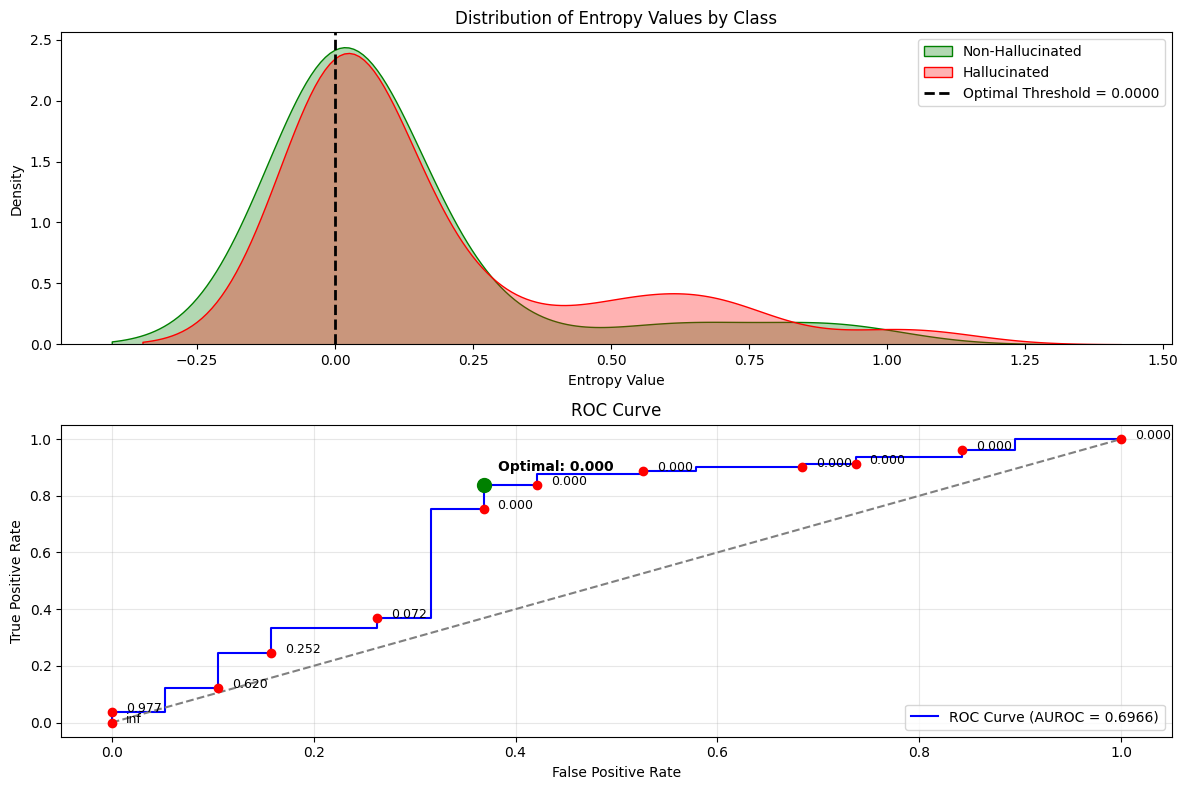

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

with open("human_sample_xor_tydiqa.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Extract ground truth labels and semantic entropy values
true_labels = []
semantic_entropy_values = []
question_ids = []
for question_id, question_data in data.items():
    # Convert labels to num (1 hallucinated, 0 non-hallucinated)
    true_label = 1 if question_data.get("question_label") == "Hallucinated" else 0

    # Store ground truth, entropy values, and question IDs
    true_labels.append(true_label)
    semantic_entropy_values.append(question_data.get("semantic_entropy"))
    question_ids.append(question_id)

true_labels = np.array(true_labels)
semantic_entropy_values = np.array(semantic_entropy_values)
question_ids = np.array(question_ids)

# Print class distribution
hallucinated_count = np.sum(true_labels == 1)
non_hallucinated_count = np.sum(true_labels == 0)
print(f"Class distribution:")
print(f"  Hallucinated: {hallucinated_count} ({hallucinated_count/len(true_labels)*100:.1f}%)")
print(f"  Non-hallucinated: {non_hallucinated_count} ({non_hallucinated_count/len(true_labels)*100:.1f}%)")

# Check relationship between entropy and hallucination
avg_entropy_hallucinated = np.mean(semantic_entropy_values[true_labels == 1])
avg_entropy_non_hallucinated = np.mean(semantic_entropy_values[true_labels == 0])
print(f"\nAverage entropy for hallucinated samples: {avg_entropy_hallucinated:.6f}")
print(f"Average entropy for non-hallucinated samples: {avg_entropy_non_hallucinated:.6f}")

# Compute AUROC score for original entropy values
auroc_original = roc_auc_score(true_labels, semantic_entropy_values)
print(f"\nAUROC Score (Original Entropy): {auroc_original:.4f}")

entropy_for_analysis = semantic_entropy_values
auroc_for_analysis = auroc_original

# Plot ROC Curve for the selected entropy values with labeled thresholds
fpr, tpr, thresholds = roc_curve(true_labels, entropy_for_analysis)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.6f}")

# Calculate entropy value distributions by class
plt.figure(figsize=(12, 8))

# Plot distribution of entropy by class
plt.subplot(2, 1, 1)
sns.kdeplot(entropy_for_analysis[true_labels == 0],
            label="Non-Hallucinated", color="green", fill=True, alpha=0.3)
sns.kdeplot(entropy_for_analysis[true_labels == 1],
            label="Hallucinated", color="red", fill=True, alpha=0.3)
plt.axvline(optimal_threshold, color='black', linestyle='dashed',
            linewidth=2, label=f"Optimal Threshold = {optimal_threshold:.4f}")
plt.title("Distribution of Entropy Values by Class")
plt.xlabel("Entropy Value")
plt.ylabel("Density")
plt.legend()

# Create ROC curve
plt.subplot(2, 1, 2)
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUROC = {auroc_for_analysis:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  #random classifier line


num_thresholds = len(thresholds)
threshold_positions = np.linspace(0, num_thresholds-1, 12).astype(int)

# Plot threshold points and add labels
for idx in threshold_positions:
    plt.plot(fpr[idx], tpr[idx], 'ro')
    plt.annotate(f"{thresholds[idx]:.3f}",
                (fpr[idx], tpr[idx]),
                textcoords="offset points",
                xytext=(10, 0),
                ha='left',
                fontsize=9)

# Highlight the optimal threshold
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=10)
plt.annotate(f"Optimal: {optimal_threshold:.3f}",
            (fpr[optimal_idx], tpr[optimal_idx]),
            textcoords="offset points",
            xytext=(10, 10),
            ha='left',
            fontweight='bold')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("entropy_threshold_analysis_without_normalization.png", dpi=300)

# Print 10 example samples near the threshold for debugging
print("\nExample samples near the optimal threshold:")
threshold_distance = np.abs(entropy_for_analysis - optimal_threshold)
closest_indices = np.argsort(threshold_distance)[:10]

print("\nQuestion ID | True Label | Entropy | Prediction")
print("-" * 60)
for idx in closest_indices:
    q_id = question_ids[idx]
    true_label = "Hallucinated" if true_labels[idx] == 1 else "Non-Hallucinated"
    entropy = semantic_entropy_values[idx]
    entropy_for_analysis_value = entropy_for_analysis[idx]
    prediction = "Hallucinated" if entropy_for_analysis_value >= optimal_threshold else "Non-Hallucinated"

    print(f"{q_id[:10]}... | {true_label:15} | {entropy:.6f} | {prediction}")

# Calculate metrics for the optimal threshold
predictions = (entropy_for_analysis >= optimal_threshold).astype(int)
true_positive = np.sum((predictions == 1) & (true_labels == 1))
true_negative = np.sum((predictions == 0) & (true_labels == 0))
false_positive = np.sum((predictions == 1) & (true_labels == 0))
false_negative = np.sum((predictions == 0) & (true_labels == 1))

accuracy = (true_positive + true_negative) / len(true_labels)
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance at optimal threshold:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix:")
print(f"TN: {true_negative}, FP: {false_positive}")
print(f"FN: {false_negative}, TP: {true_positive}")

In [ ]:
#get a file with semantic entropy based labels
#adding label to each question based on optimal threshold
for i, question_id in enumerate(question_ids):
    entropy = semantic_entropy_values[i]
    predicted_label = "Hallucinated" if entropy >= optimal_threshold else "Non-Hallucinated"
    data[question_id]["question_label_SE"] = predicted_label

# Save the updated data to a new file
with open("human_SE_sample_xor_tydiqa.json", "w", encoding="utf-8") as f_out:
    json.dump(data, f_out, indent=2, ensure_ascii=False)

print(f"\nUpdated file saved as 'human_SE_sample_xor_tydiqa.json'")


Updated file saved as 'human_SE_sample_xor_tydiqa.json'


# labeling the full data based on achieved threshold


In [ ]:
fullDataFile="/content/semantic_entropy_Llama3.1-8b_xor_tydiqa_results.json"
with open(fullDataFile, "r", encoding="utf-8") as f:
    data = json.load(f)

# Add a label based on semantic entropy
for qid, info in data.items():
    entropy = info.get("semantic_entropy", 0)
    label = "Hallucinated" if entropy >= optimal_threshold else "Non-Hallucinated" #optimal threshold here is 0
    info["SE_question_label"] = label

# Save to a new file
with open("labeled_data_XORfull_SE.json", "w", encoding="utf-8") as f_out:
    json.dump(data, f_out, indent=2, ensure_ascii=False)

print("File with labels saved as 'labeled_data_XORfull_SE.json'")


File with labels saved as 'labeled_data_XORfull_SE.json'


# comparing RougeL and SE labels

Label distribution in ground truth (RougeL): {'Non-Hallucinated': 31, 'Hallucinated': 677}
Label distribution in predictions (SE): {'Non-Hallucinated': 183, 'Hallucinated': 525}

Classification Metrics:
Accuracy:  0.7345
Precision: 0.9657
Recall:    0.7489
F1 Score:  0.8436

Confusion Matrix Statistics:
True Positives (TP): 507
False Positives (FP): 18
True Negatives (TN): 13
False Negatives (FN): 170
Confusion matrix saved as 'confusion_matrix.png'


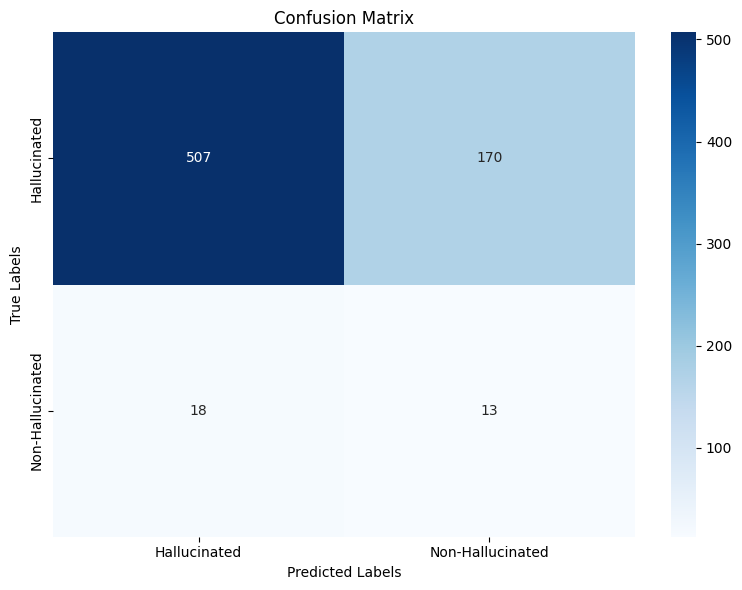

In [8]:
import json
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def calculate_metrics(ground_truth_file, prediction_file):
    # Load data from files
    ground_truth_data = load_json_file(ground_truth_file)
    prediction_data = load_json_file(prediction_file)

    # Initialize lists to store true and predicted labels
    y_true = []
    y_pred = []

    # Process each question ID that exists in both files
    ids = set(ground_truth_data.keys()).intersection(set(prediction_data.keys()))

    for question_id in ids:
        # Extract the labels
        true_label = ground_truth_data[question_id].get("computed_question_label")
        pred_label = prediction_data[question_id].get("SE_question_label")

        y_true.append(true_label)
        y_pred.append(pred_label)

    # Print label distribution for analysis
    print(f"Label distribution in ground truth (RougeL): {dict((x, y_true.count(x)) for x in set(y_true))}")
    print(f"Label distribution in predictions (SE): {dict((x, y_pred.count(x)) for x in set(y_pred))}")

    # Get labels in sorted order (for consistent confusion matrix)
    labels = sorted(list(set(y_true).union(set(y_pred))))

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "recall": recall_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "f1_score": f1_score(y_true, y_pred, pos_label="Hallucinated", average='binary'),
        "confusion_matrix": confusion_matrix(y_true, y_pred, labels=labels),
        "labels": labels
    }

    return metrics

def plot_confusion_matrix(conf_matrix, labels):
    """Plot confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix saved as 'confusion_matrix.png'")
    plt.show()

def print_confusion_matrix_stats(conf_matrix, labels):
      # Find which index corresponds to the positive class ("Hallucinated")
      pos_index = labels.index("Hallucinated") if "Hallucinated" in labels else 0
      neg_index = 1 - pos_index  # The other index

      tn = conf_matrix[neg_index, neg_index]
      fp = conf_matrix[neg_index, pos_index]
      fn = conf_matrix[pos_index, neg_index]
      tp = conf_matrix[pos_index, pos_index]

      print("\nConfusion Matrix Statistics:")
      print(f"True Positives (TP): {tp}")
      print(f"False Positives (FP): {fp}")
      print(f"True Negatives (TN): {tn}")
      print(f"False Negatives (FN): {fn}")



predictions_file = "/content/labeled_data_XORfull_SE.json" # se labels file
ground_truth_file="/content/labeled_data_XORfull_rougel_isri.json" #RougeL labels file

metrics = calculate_metrics(ground_truth_file, predictions_file)

# Print the results
print("\nClassification Metrics:")
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1_score']:.4f}")

# Print and plot confusion matrix
conf_matrix = metrics['confusion_matrix']
labels = metrics['labels']

print_confusion_matrix_stats(conf_matrix, labels)
plot_confusion_matrix(conf_matrix, labels)